# SVM with rbf kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '2051', '4481', '3107', '1243', '11234'][:5]

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 4496
Testing set length for 10795: 1498
Cross-validation set length for 10795: 1498
Training set length for 12098: 3592
Testing set length for 12098: 1197
Cross-validation set length for 12098: 1197
Training set length for 11618: 3792
Testing set length for 11618: 1264
Cross-validation set length for 11618: 1264
Training set length for 2051: 3635
Testing set length for 2051: 1211
Cross-validation set length for 2051: 1211
Training set length for 4481: 3903
Testing set length for 4481: 1301
Cross-validation set length for 4481: 1301


In [3]:
dfs[stocks[0]].head(5)

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-13 10:57:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1489.0, 1874.0), (1490.0, 4866.0), (1491.0, ...",1488.0,1489.0,1488.5,1874.0,800.0,1.0,-0.401645
2013-09-13 10:59:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 220.0), (1491.0, 3642.0), (1492.0, 5...",1488.0,1490.0,1489.0,220.0,3967.0,1.0,0.894913
2013-09-13 11:00:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1491.0, 905.0), (1492.0, 5591.0), (1493.0, 6...",1489.0,1491.0,1490.0,905.0,2807.0,1.0,0.512392
2013-09-13 11:01:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1492.0, 4077.0), (1493.0, 6616.0), (1494.0, ...",1490.0,1492.0,1491.0,4077.0,1563.0,0.0,-0.445745
2013-09-13 11:03:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 1738.0), (1491.0, 4491.0), (1492.0, ...",1488.0,1490.0,1489.0,1738.0,4642.0,1.0,0.455172


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

After that we will try to get the best combination of the parameters.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-maring hyperplane, so there may be more mislassiciations

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

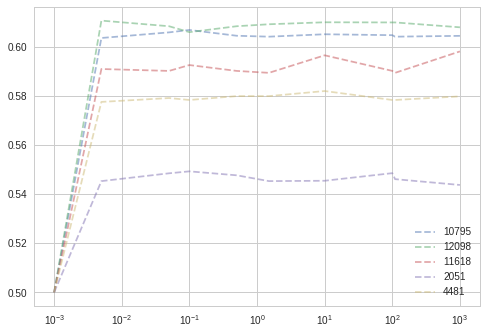

In [5]:
cs = [0.001, 0.005, 0.05, 0.1, 0.5, 1.5, 10, 110, 1000]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'rbf', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

There is no rule, how to set this parameter - for stock **11618** the value is very large, for the rest it is rather small.

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.1
For 12098 the best is 0.005
For 11618 the best is 1000.0
For 2051 the best is 0.1
For 4481 the best is 10.0


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For two stocks **10795** and **12098** it can affect the prediction by 0.1, for the rest the difference is less.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.10692271599255687
For 12098 the diff between best and worst 0.11073369565217384
For 11618 the diff between best and worst 0.09818538241413244
For 2051 the diff between best and worst 0.04932019183029901
For 4481 the diff between best and worst 0.08204346078361824


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

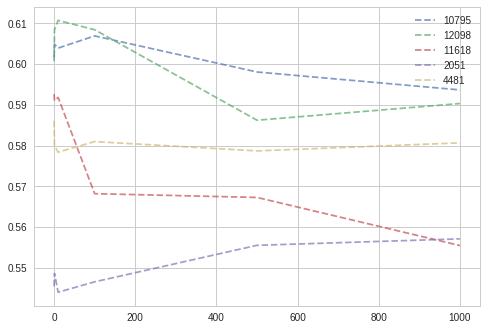

In [8]:
gammas = [0.1, 1, 10, 100, 500, 1000]

df_gammas = {}

for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'rbf', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.7)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter - for stock **2051** the value is very large, for the rest it is rather small.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 100.0
For 12098 the best is 10.0
For 11618 the best is 0.1
For 2051 the best is 1000.0
For 4481 the best is 0.1


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For all stocks the error difference is small - less than 0.04.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.013265431735344335
For 12098 the diff between best and worst 0.02451942431561982
For 11618 the diff between best and worst 0.037204918094351
For 2051 the diff between best and worst 0.013109222148870447
For 4481 the diff between best and worst 0.007726230167174997


# Results

We compare results of the SVMs with the best choices of parameters against the logistic regression and SVM with defaults.

We will use two approaches for choosing parameters:
* naive - for each stock we will just pick the best values we found in the previous section
* grid - we will caluclate roc_area error for every combination of parameters used in previous section (computionally heavy).

We could also use GridSearchCV from sklearn library, but the issue with it is supplying the cross-validation set (it has to be continous in time). In the future we need to implement the method for that.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set.

For two stocks **12098** and **11618** the roc_area scores are better, for the rest it's slightly worse for testing set. So this approach doesn't work so well.

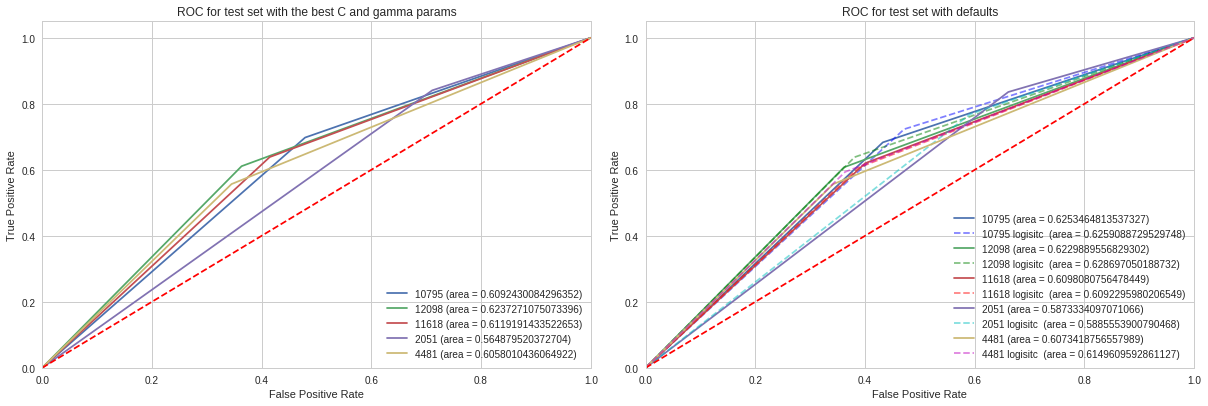

In [93]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

### Grid approach

We iterate over all combinations of parameters C and gamma.

This approach works usually better, but not for all cases.

In [12]:
best_c = {}
best_g = {}
best_score = {}

for s in stocks:
    print(s)
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'rbf', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            if not best_score.get(s):
                best_score[s] = logit_roc_auc
            if logit_roc_auc >= best_score[s]:
                best_c[s] = c
                best_g[s] = g
                best_score[s] = logit_roc_auc

10795
12098
11618
2051
4481


In [13]:
print('stock', '\t', 'C', '\t', 'gamma', '\t', 'best score')
for s in stocks:
    print(s, '\t', best_c[s], '\t', best_g[s], '\t', best_score[s])

stock 	 C 	 gamma 	 best score
10795 	 1000 	 10 	 0.610658552729
12098 	 10 	 0.1 	 0.610796598229
11618 	 1000 	 1 	 0.598185382414
2051 	 100 	 100 	 0.575152629483
4481 	 1.5 	 0.1 	 0.588725733608


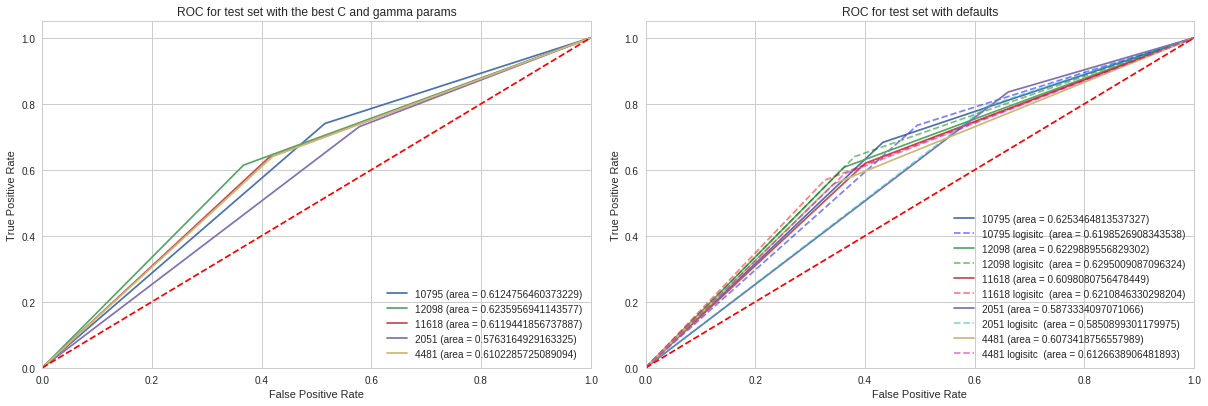

In [94]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=best_c[s], gamma=best_g[s])
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

# Conclusions


The **C** parameter for **rbf** kernel should be choosen for each stock separately. The choice of **C** paramter matters - the difference between roc_area scoring between the worst and best case is about $0.1$ for each stock of this choice. The only thing in common is that C should be bigger than $0.0001$. But suprisingly only for one of the stock data - the bigger **C** the better.


The **gamma** parameter for **rbf** kernel should be choosen for each stock separately. The choice of **gamma** doesn't seem to matter much though - the difference it can make is about $0.01$. 

The **C** and **gamma** should be choosen together, there is no point in picking the best one for each of them. Choosing them using *grid* approach gave small improvement for 3 stocks, for the rest default parameters worked better.

Comparing to logistic regression for each stock we have slightly worse results with "tunned" parameters. For **10795** and **2051** we have better results with defult parameters than for logistic regression.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>
2. [RBF kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/)
3. [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)